# Notebook for generating state

<!-- ## TO DO
<!-- - find source for rotation operation of CV state (just using copilot solution) -->
<!-- - find way to sample marginal distribution  -->
<!-- - recontruct state using samples -->


In [2]:
from numpy.typing import NDArray

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from numba import njit
from scipy.stats import norm, multivariate_normal, uniform
from scipy.integrate import simpson, trapezoid, romb
from tqdm.notebook import tqdm, trange
# from tqdm import trange
# from tqdm.notebook import trange
import time
import pickle
import json


## Testing nested `tqdm`

In [3]:
for i in tqdm(range(6), desc="Outer loop"):
    for j in tqdm(range(10), desc=f"Inner loop {i}", leave=bool(i == 6)):
        time.sleep(0.1)

Outer loop:   0%|          | 0/6 [00:00<?, ?it/s]

Inner loop 0:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop 1:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop 2:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop 3:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop 4:   0%|          | 0/10 [00:00<?, ?it/s]

Inner loop 5:   0%|          | 0/10 [00:00<?, ?it/s]

## Background

**Goal:** Generate CV states and Corresponding Wigner function for use in marginal probability distribution $P(X_\theta)$ in phase-space. Sample the marginals for a range of angles and save the data $(X_\theta, \theta)$ for reconstruction

By simulating the data, we can check for the exact solution after of the state reconstruction.

Workflow:
- Using `qutip` we can easily generate an arbitrary continous-variable (CV) state for use as the groundtruth
- Create Wigner function for groundtruth
- Compute marginal distribution of Wigner function, $P(X_\theta)$, for a range of $\theta$
- Use the marginal probability distribution for reconstruction of state
- Measure in $X_\theta = \frac{1}{\sqrt{2}}\left(\hat{a}e^{-i\theta} + \hat{a}^\dagger e^{i\theta}\right)$ in [recontruction notebook](reconstruct.ipynb)


In [4]:

def generate_cv_state(state_type : str ="vacuum", N : int=30, **kwargs):
    """Generate a continuous variable quantum state.

    This function can create different types of continuous variable states,
    including vacuum, coherent, and squeezed states (more to be included)
    
    Parameters
    ---
    state_type : str
        The type of state to generate. Options are "vacuum", "coherent", and "squeezed".
    N : int
        The dimension of the Hilbert space.
    **kwargs : dict
        Additional parameters for specific state types.
    """
    if state_type == "vacuum":
        return qt.basis(N, 0)
    
    elif state_type == "coherent":
        kwargs.setdefault("alpha", 0.0 + 0j)  # Default value for alpha in case it is not applied
        kwargs.pop("parity", None)  # Remove parity from kwargs to avoid passing it to qt.coherent
        return qt.coherent(N, **kwargs)
    
    elif state_type == "squeezed":
        r = kwargs.get("r", 0.5)
        return qt.squeeze(N, r, **kwargs)
    elif state_type == "cat":
        # Generate a cat state using coherent states
        alpha = kwargs.get("alpha", 2.0)
        parity = kwargs.get("parity", "even")
        return cat_state(N, alpha=alpha, parity=parity)

    else:
        raise ValueError(f"Unknown state type: {state_type}")


def cat_state(N, alpha=2.0, parity="even"):
    coh_p = generate_cv_state("coherent", N, alpha=alpha)
    coh_m = generate_cv_state("coherent", N, alpha=-alpha)

    if parity == "even":
        return (coh_p + coh_m).unit()
    elif parity == "odd":
        return (coh_p - coh_m).unit()
    else:
        raise ValueError(f"Unknown parity: {parity}")

    
def rotate_state(rho, theta):
    rho = rho if rho.isoper else qt.ket2dm(rho)
    N = rho.shape[0]
    a = qt.destroy(N)
    U = (1j*theta * a.dag() * a).expm()
    return U * rho * U.dag()

test = generate_cv_state("coherent", 3, alpha=2 - 2j)


In [5]:
def wigner_grid(rho : qt.Qobj | NDArray[np.float64], xmax : float | int=5., pmax : float | int=5., n : int=201, method : str ="clenshaw"):
    """Generate a Wigner grid for a given quantum state.

    rho : qt.Qobj | NDArray[np.float64]
        The density matrix or state vector of the quantum system.
        This can be a QuTiP object or a NumPy array.
    xmax : float | int
        The maximum value of the position variable.
    pmax : float | int
        The maximum value of the momentum variable.
    n : int
        The number of points in the grid.
        This determines the resolution of the Wigner function.
    method : str
        The method used for computing the Wigner function.
        This can be "clenshaw", "laguerre", "iterative", or "fft". See `qt.wigner()` for details.

    :doctest:
    >>> x, p, W = wigner_grid(rho, xmax=5, pmax=5, n=201, method="clenshaw")
    >>> W.shape
    (201, 201)

    """
    x = np.linspace(-xmax, xmax, n)
    p = np.linspace(-pmax, pmax, n)
    Xgrid, Pgrid = np.meshgrid(x, p)
    
    W = qt.wigner(rho, x, p, 
                  method=method,
                  )

    return x, p, W
X, P, W = wigner_grid(test)
X.shape, P.shape, W.shape

((201,), (201,), (201, 201))

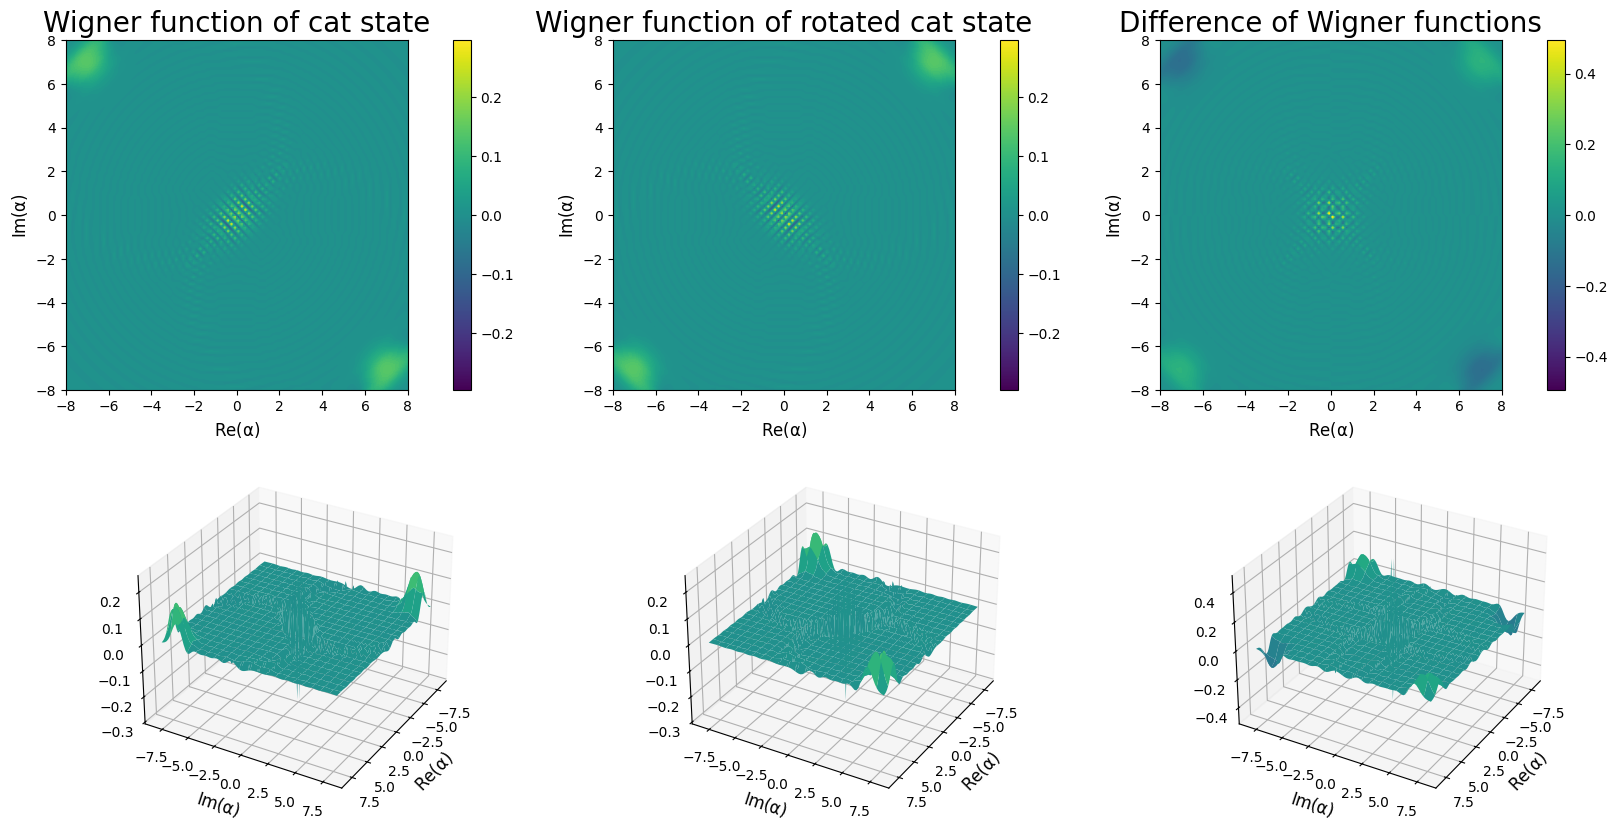

In [6]:
# plotting to ensure correct wigner function (takes ~40s to plot)
N = 100
alpha = -6 + 6.j # displacement
state_type = "cat" # state
parity = "odd" # parity for cat state |alpha> +- |-alpha>
state = generate_cv_state(state_type, 60, alpha=alpha, parity=parity) 
state_rotate = rotate_state(state, np.pi/2)
x = np.linspace(-8, 8, N)
p = np.linspace(-8, 8, N)

fig = plt.figure(figsize=(20,10))

axes = []
# first row of (2D) subplots
ax = fig.add_subplot(2, 3, 1)
axes.append(ax)
qt.plot_wigner(state, x, p, 
               cmap="viridis", fig=fig, ax=ax, colorbar=True, projection="2d", method="laguerre")

ax = fig.add_subplot(2, 3, 2)
axes.append(ax)
qt.plot_wigner(state_rotate, x, p, 
               cmap="viridis", fig=fig, ax=ax, colorbar=True, projection="2d", method="laguerre")

ax = fig.add_subplot(2, 3, 3)
axes.append(ax)
qt.plot_wigner(state_rotate - state.proj(), x, p, 
               cmap="viridis", fig=fig, ax=ax, colorbar=True, projection="2d", method="laguerre")

# second row of (3D) subplots
ax = fig.add_subplot(2, 3, 4, projection="3d")
axes.append(ax)
qt.plot_wigner(state, x, p, 
               cmap="viridis", fig=fig, ax=ax, colorbar=False, projection="3d", method="laguerre")

ax = fig.add_subplot(2, 3, 5, projection="3d")
axes.append(ax)
qt.plot_wigner(state_rotate, x, p,
               cmap="viridis", fig=fig, ax=ax, colorbar=False, projection="3d", method="laguerre")

ax = fig.add_subplot(2, 3, 6, projection="3d")
axes.append(ax)
qt.plot_wigner(state_rotate - state.proj(), x, p,
               cmap="viridis", fig=fig, ax=ax, colorbar=False, projection="3d", method="laguerre")


axes[0].set_title("Wigner function of cat state", fontsize=20)
axes[1].set_title("Wigner function of rotated cat state", fontsize=20)
axes[2].set_title("Difference of Wigner functions", fontsize=20)


for a in axes[3:]:
    a.view_init(elev=30, azim=30)

   
# fig.tight_layout()

## Computing marginal distributions


Compute marginals by rotating state and measure along $X$

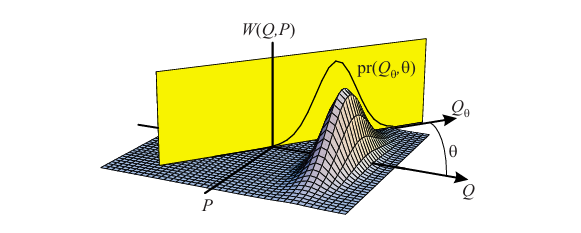

In [7]:
def marginal_from_wigner(W, p, axis="x"):
    """
    Compute a marginal by integrating the Wigner function along one axis.  
    axis='p' gives ∫ W(x,p) dp -> P(x); axis='x' gives ∫ W(x,p) dx -> P(p).
    """
    if axis == "x":
        dx = p[1] - p[0]  # reuse grid spacing argument if needed
        P, dist = simpson(W, axis=1, dx=dx), dx  # integrate over x (position -- columns) return number of rows
    elif axis == "p":
        dp = p[1] - p[0]
        P, dist = simpson(W, axis=0, dx=dp), dp  # integrate over p (momentum -- rows) return number of columns
    else:
        raise ValueError("axis must be 'p' or 'x'")
    return P, dist


def marginal_angles(state, thetas, axis="p"):
    marginals = {}
    measurements = []
    thetalist = []
    for i in tqdm(range(len(thetas)), desc="Computing marginals"):
        rot = rotate_state(state, thetas[i])
        x, p, W = wigner_grid(rot, n=202, xmax=8, pmax=8)
        marginals[i], _ = marginal_from_wigner(W, p, axis=axis)
        thetalist.append([thetas[i]]*len(marginals[i]))
        measurements.append(marginals[i])
    
    if axis == "x": # variable of integration: p -- variable left in marginal: x
        marginals["P"] = p
    elif axis == "p": # variable of integration: x -- variable left in marginal: p
        marginals["X"] = x
    thetalist = np.array(thetalist)
    measurements = np.array(measurements)
    print(thetalist.shape)
    print(measurements.shape)
    return marginals, np.array((thetalist.ravel(), measurements.ravel()))


In [8]:
state = generate_cv_state("cat", 50, alpha=2.0 + 1j, parity="even")  # generate a cat state
thetas = [np.pi/6 * i for i in range(6)]
marginals, measurements = marginal_angles(state, thetas, axis="p")

Computing marginals:   0%|          | 0/6 [00:00<?, ?it/s]

(6, 202)
(6, 202)


In [9]:
#check that the cumsum is 1
for i in range(6):
    print(marginals[i].sum() * (marginals["X"][1] - marginals["X"][0]))
    # print(marginals[i].max())

0.9999999999999083
0.9999999999999737
0.9999999999962291
0.9999999999998584
0.9999999999999806
0.9999999999975596


Plotting marginals:   0%|          | 0/6 [00:00<?, ?it/s]

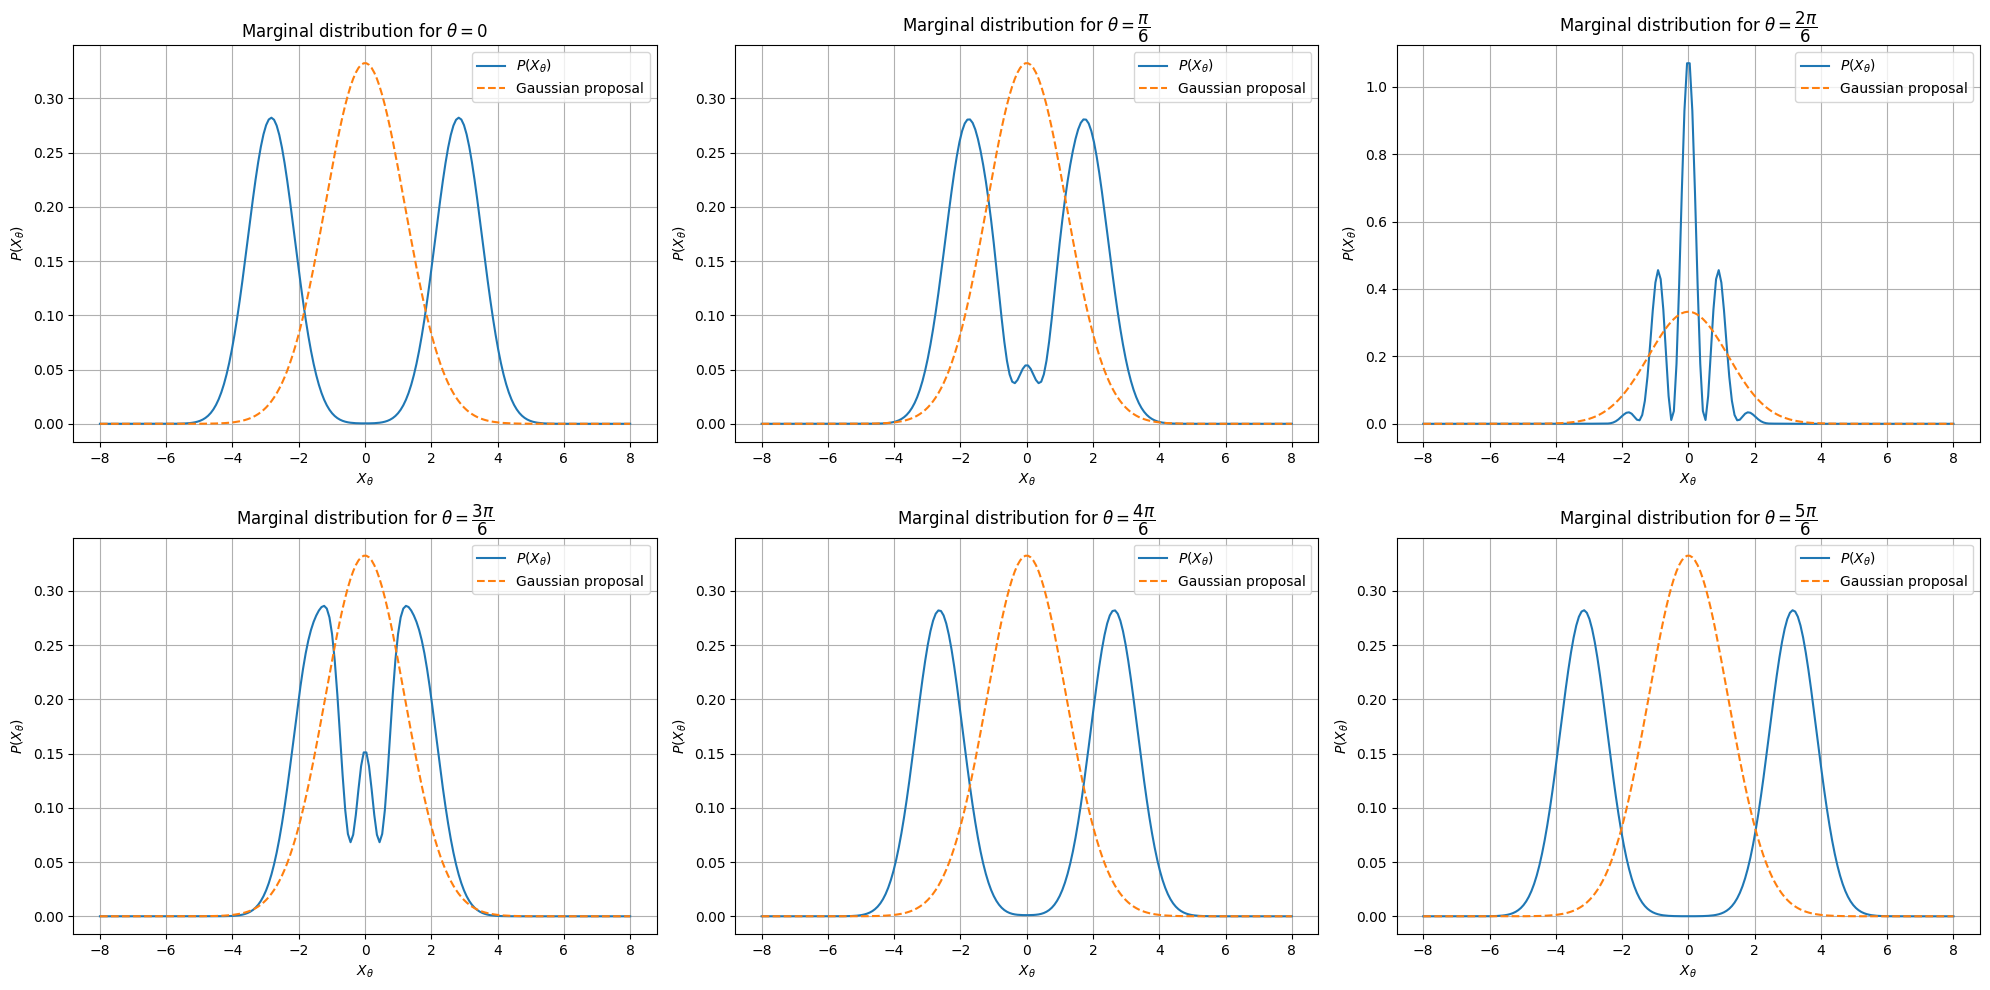

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
labs = [r"$0$", r"$\dfrac{\pi}{6}$"] + [rf"$\dfrac{{{i}\pi}}{{6}}$" for i in range(2, 6)]
for i in tqdm(range(6), desc="Plotting marginals"):
    ax = axes[i//3, i%3]
    ax.plot(marginals["X"], marginals[i], label=r"$P(X_{\theta})$")
    mu = marginals[i] @ marginals["X"] # <X> = sum_i p_i*x_i
    gaus = norm(loc=mu, scale=1.2).pdf(marginals["X"])
    ax.plot(marginals["X"], gaus, label="Gaussian proposal", linestyle="--")
    # ax.axvline(mu, color="k", linestyle="-", label="mean")
    ax.set_title(f"Marginal distribution for $\\theta=${labs[i]}")
    ax.set_xlabel(r"$X_{\theta}$")
    ax.set_ylabel(r"$P(X_{\theta})$")
    ax.legend()
    ax.grid()

fig.tight_layout()

## Rejection Sampling

In [11]:
def rejection_sampling(target_pdf, proposal_pdf, proposal_sampler, n_samples, i, marginals):
    
    samples = []
    with tqdm(total=n_samples, desc=f"Rejection sampling for theta={i/np.pi:.3f}pi") as pbar:
        while (len(samples) < n_samples): # condition
            
            # xmin_index = np.argwhere(np.isclose(marginals[i], 0))[-1] # get the highest index for zero value
            # xmax_index = np.argwhere(np.isclose(marginals[i], 0))[0] # get the lowest index for zero value
            # x = proposal_sampler(xmin=marginals["X"][xmin_index], xmax=marginals["X"][xmax_index])  # Sample from proposal distribution
            x = proposal_sampler()  # Sample from proposal distribution
            if  marginals["X"].min() > x and x > marginals["X"].max():
                pbar.set_postfix({"rejected": x})
                pbar.update(0)
                continue  # Skip samples outside the range of marginals["X"]
            u = np.random.uniform(0, 1)
            
            q = proposal_pdf(x)
            
            p = target_pdf(x, i)
            if p is None:
                pbar.set_postfix({"rejected": x})
                pbar.update(0)
            elif u * q <= p:
                # print(f"appending {x:.3f}")
                samples.append(x)
                pbar.update(1)
                

    return samples


# Example usage:
def target_pdf(x, i=0):
    X = marginals["X"]
    index_mask = np.isclose(X, x, atol=5e-3)  # Adjusted tolerance
    index = np.argwhere(index_mask) # find index for bool

    assert len(index.shape) == 2, f"should always returns a nested list"
    if index.shape[0] > 0:
        index = index[index.shape[0] // 2]
        return marginals[i][index]

    elif index.shape[0] == 0:
        return None


proposal_sampler = lambda: np.random.normal(loc=0, scale=1) # Example proposal sampler

# proposal_sampler = lambda xmin, xmax: np.random.uniform(xmin, xmax) # Example proposal sampler

def get_samples(marginals, n_samples=500, sampler="rejection"):
    xs = {}
    for i in trange(6, desc="Sampling"):
    # for i in range(6):
        target = lambda x, i=i: target_pdf(x, i)
        proposal = norm(loc=marginals["X"] @ marginals[i], scale=1.2).pdf  # Proposal PDF
        if sampler == "rejection":
            xs[i] = rejection_sampling(target, proposal, proposal_sampler, n_samples=n_samples, i=i, marginals=marginals)
            
        elif sampler == "choice":
            dx = marginals["X"][1] - marginals["X"][0]
            prob = marginals[i] * dx

            # find index for negative values
            index_negative = np.argwhere(prob < 0)

            # raise error if all negative values not close to zero
            if not (np.isclose(prob[index_negative], 0)).all():
                raise ValueError(f"prob negatives : {prob[index_negative].ravel()}")

            # set negative values to zero
            prob = np.where(prob < 0, 0, prob)
            xs[i] = np.random.choice(marginals["X"], p=prob, replace=True, size=n_samples)
        else:
            raise ValueError(f"Unknown sampling type: {sampler}")

    return xs

samples = get_samples(marginals, n_samples=100_000, sampler="choice")

Sampling:   0%|          | 0/6 [00:00<?, ?it/s]

## Plot samples  

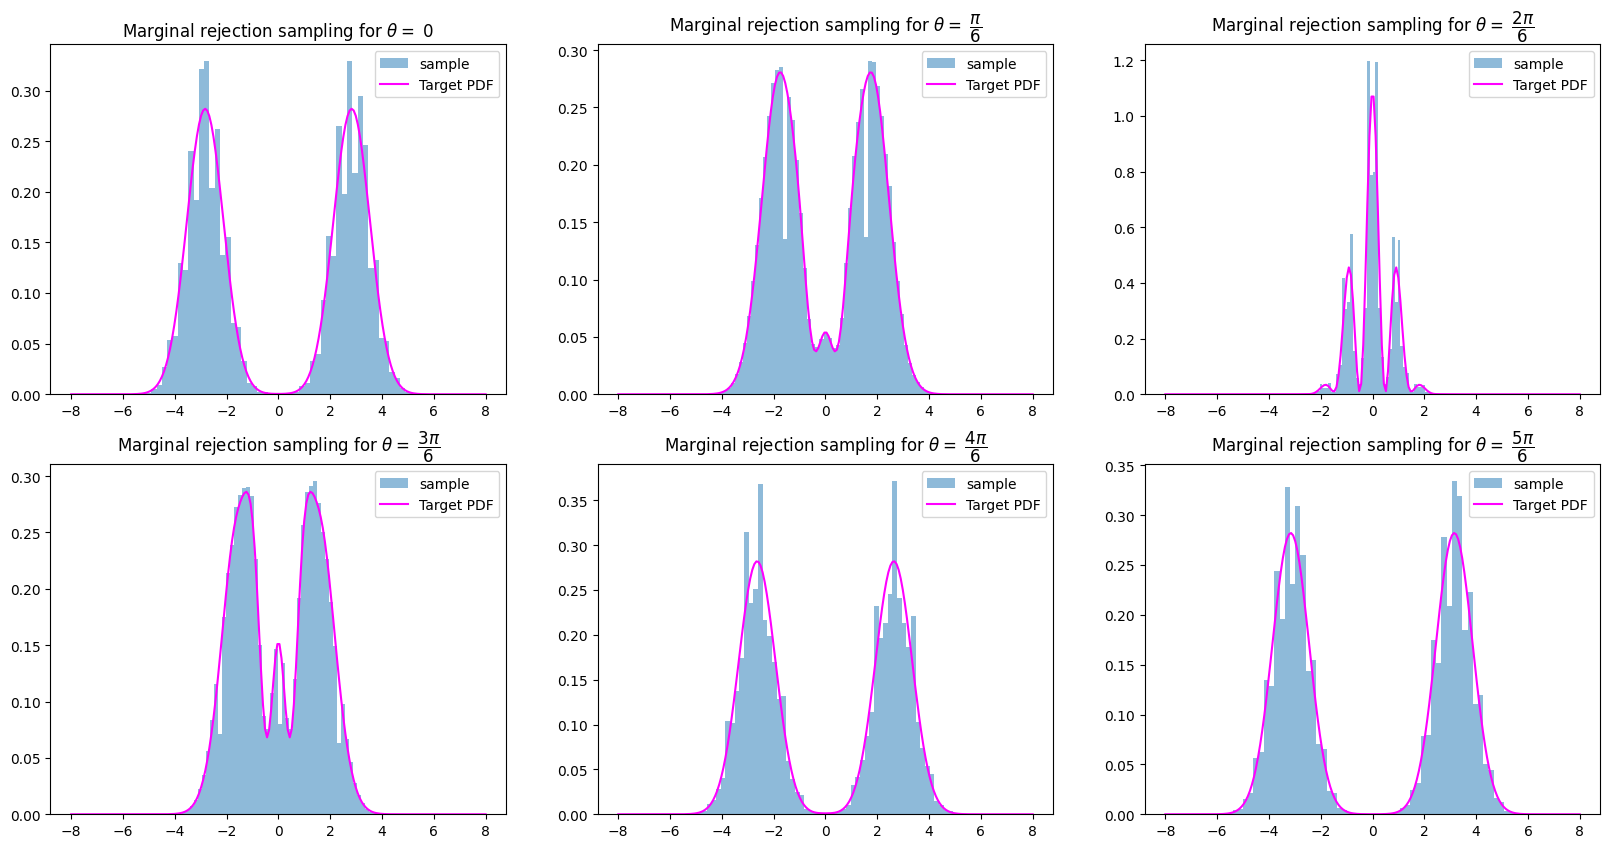

In [12]:
fig, axes = plt.subplots(2,3, figsize=(20, 10))

for i, ax in enumerate(axes.flatten()):
    ax.hist(samples[i], bins=60, density=True, label=f"sample", alpha=0.5)
    ax.plot(marginals["X"], marginals[i], label="Target PDF", color="magenta")
    # ax.plot(marginals["X"], norm.pdf(marginals["X"], loc=marginals["X"] @ marginals[i], scale=1.2), label="Proposal PDF", color="orange", linestyle="--")
    ax.set_title(f"Marginal rejection sampling for $\\theta =$ {labs[i]}")
    ax.legend()
    

## Pickle data

In [13]:
t = measurements[0,:]
mes = measurements[1,:]
np.savez("measurements.npz", thetas=t, measurements=mes)
with open("measurements_metadata.txt", "w") as f:
    f.write(f"state_type,{state_type}\n")
    f.write(f"parity,{parity}\n")
    f.write(f"alpha,{alpha}\n")
    f.write(f"thetas [radians],{thetas}\n")


np.load("measurements.npz")

NpzFile 'measurements.npz' with keys: thetas, measurements

# Debugging
## Check to see which axis is real and which is imaginary


ValueError: incompatible dimensions [[60], [60]] and [[50], [50]]

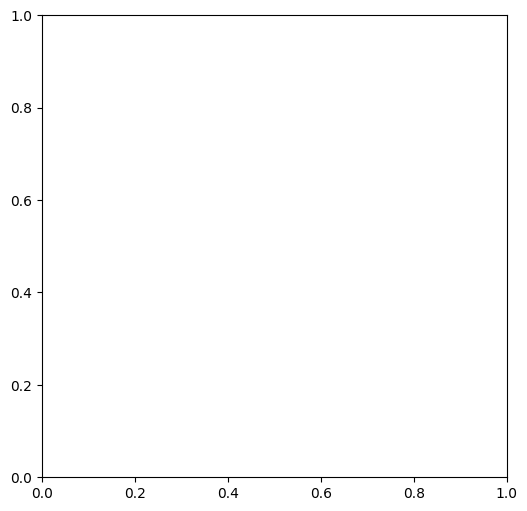

In [14]:
state = generate_cv_state(state_type, 50, alpha=alpha, parity=parity) 

x = np.linspace(-8, 8, 70)
p = x.copy()
fig, ax = plt.subplots(figsize=(6, 6))
X, P = np.meshgrid(x, p)
diff = state_rotate - state.proj()
# print(X.shape, P.shape, Z.shape)
Z = qt.wigner(diff, x, p)
plot = ax.contourf(X,P, Z, extent=[-8, 8, -8, 8], levels=20, cmap="RdBu")
ax.set(xlabel="Re($\\alpha$)", ylabel="Im($\\alpha$)", title="Wigner function of difference state")
fig.colorbar(plot, ax=ax, orientation='vertical')
with np.printoptions(precision=2, suppress=True, linewidth=160, edgeitems=12):
    print(f"Wigner function,  shape = {Z.shape}:")
    print(Z)
    